<a href="https://colab.research.google.com/github/Pedro1Guevara/proyectofinalcd/blob/main/PROYECTO_FINAL_CIENCIA_DE_DATOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Link del dataset
https://www.kaggle.com/datasets/yanmaksi/big-startup-secsees-fail-dataset-from-crunchbase
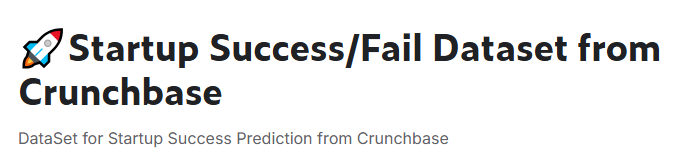

# **Preguntas a responder**
* ¿Existe un umbral de financiamiento que se asocie con la supervivencia de una startup?
* ¿Existe una relación entre la supervivencia de la startup y el sector de la industria donde se maneja?
* ¿Existe una relación con el número de rondas de financiamiento de una startup en su supervivencia?


# **Procesamiento de datos**

**Librerías Usadas**
* Pandas
* IPython.display
* Matplotlib
* Scikit-learn
* Statsmodels
* Seaborn
* Numpy





In [ ]:
import pandas as pd

# Leer el archivo CSV directamente desde un enlace en GitHub
big_startup_secsees_og_df = pd.read_csv('https://raw.githubusercontent.com/Pedro1Guevara/proyectofinalcd/master/big_startup_secsees.csv')

# Mostrar las primeras 5 filas del DataFrame para revisar la estructura y contenido de los datos
big_startup_secsees_og_df.head()

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24


**Atributos**
 * permalink (string): Identificador único.
 * name (string): Nombre de la startup.
 * homepage_url (string): URL de la página web.
 * category_list (string): Categorías del negocio.
 * funding_total_usd (int): Monto total de financiamiento.
 * status (string): Estado operativo de la startup (operando, cerrado, etc.).
 * country_code (string): Código de país.
 * region, city (string): Localización geográfica.
 * funding_rounds (int): Número de rondas de financiamiento.
 * founded_at, first_funding_at, last_funding_at (dates): Fechas relacionadas con el inicio y financiamiento.

**Limpieza de datos**

In [ ]:
from datetime import datetime

# Crear una copia del dataset original
big_startup_secsees_df = big_startup_secsees_og_df.copy()

# Convertir 'funding_total_usd' a numérico y llenar nulos con 0
big_startup_secsees_df['funding_total_usd'] = pd.to_numeric(big_startup_secsees_df['funding_total_usd'], errors='coerce').fillna(0)

# Lista de columnas de fecha
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at']

# Convertir columnas de fecha a tipo datetime
for column in date_columns:
    big_startup_secsees_df[column] = pd.to_datetime(big_startup_secsees_df[column], errors='coerce')

# Obtener la fecha actual
current_date = datetime.now()

# Corregir valores en las columnas de fecha fuera de rango
for column in date_columns:
    big_startup_secsees_df[column] = big_startup_secsees_df[column].apply(
        lambda x: datetime(1960, 1, 1) if x and x.year < 1960 else
                  current_date if x and x > current_date else x
    )

# Copiar valores de 'last_funding_at' a 'first_funding_at' y 'founded_at' si están vacíos
big_startup_secsees_df['first_funding_at'] = big_startup_secsees_df.apply(
    lambda row: row['last_funding_at'] if pd.isnull(row['first_funding_at']) else row['first_funding_at'], axis=1
)

big_startup_secsees_df['founded_at'] = big_startup_secsees_df.apply(
    lambda row: row['last_funding_at'] if pd.isnull(row['founded_at']) else row['founded_at'], axis=1
)



In [ ]:
# Crear un mapeo entre 'country_code' y 'region' utilizando el primer valor no nulo para cada grupo
region_mapping = big_startup_secsees_df.groupby('country_code')['region'].first().to_dict()

# Rellenar valores nulos en 'region' utilizando el mapeo creado
# Si 'region' es nulo, se busca el valor correspondiente a 'country_code' en el diccionario
# Si no existe un mapeo, se asigna 'unknown'
big_startup_secsees_df['region'] = big_startup_secsees_df.apply(
    lambda row: region_mapping.get(row['country_code'], 'unknown') if pd.isnull(row['region']) else row['region'],
    axis=1
)

# Crear un mapeo entre 'region' y 'country_code' utilizando el primer valor no nulo para cada grupo
country_code_mapping = big_startup_secsees_df.groupby('region')['country_code'].first().to_dict()

# Rellenar valores nulos en 'country_code' utilizando el mapeo creado
# Si 'country_code' es nulo, se busca el valor correspondiente a 'region' en el diccionario
# Si no existe un mapeo, se asigna 'unknown'
big_startup_secsees_df['country_code'] = big_startup_secsees_df.apply(
    lambda row: country_code_mapping.get(row['region'], 'unknown') if pd.isnull(row['country_code']) else row['country_code'],
    axis=1
)

# Contar valores nulos actualizados después de completar los valores de 'region' y 'country_code'
updated_null_counts = big_startup_secsees_df.isnull().sum()

# Mostrar el conteo actualizado de valores nulos en el dataset
updated_null_counts


,0
permalink,0
name,1
homepage_url,5058
category_list,3148
funding_total_usd,0
status,0
country_code,6958
state_code,8547
region,9
city,8028


In [ ]:
# Crear un mapeo entre 'country_code' y 'city' utilizando el primer valor no nulo para cada grupo
city_mapping = big_startup_secsees_df.groupby('country_code')['city'].first().to_dict()

# Rellenar valores nulos en 'city' utilizando el mapeo creado
# Si 'city' es nulo, se busca el valor correspondiente a 'country_code' en el diccionario
# Si no existe un mapeo, se asigna 'unknown'
big_startup_secsees_df['city'] = big_startup_secsees_df.apply(
    lambda row: city_mapping.get(row['country_code'], 'unknown') if pd.isnull(row['city']) else row['city'],
    axis=1
)

# Crear un mapeo entre 'city' y 'country_code' utilizando el primer valor no nulo para cada grupo
country_code_mapping = big_startup_secsees_df.groupby('city')['country_code'].first().to_dict()

# Rellenar valores nulos en 'country_code' utilizando el mapeo creado
# Si 'country_code' es nulo, se busca el valor correspondiente a 'city' en el diccionario
# Si no existe un mapeo, se asigna 'unknown'
big_startup_secsees_df['country_code'] = big_startup_secsees_df.apply(
    lambda row: country_code_mapping.get(row['city'], 'unknown') if pd.isnull(row['country_code']) else row['country_code'],
    axis=1
)

# Contar valores nulos actualizados después de completar los valores de 'city' y 'country_code'
updated_null_counts = big_startup_secsees_df.isnull().sum()

# Mostrar el conteo actualizado de valores nulos en el dataset
print("Valores nulos actualizados por columna:")
print(updated_null_counts)

# Mostrar las primeras filas del DataFrame para verificar los cambios realizados
print("\nVista previa del DataFrame actualizado:")
display(big_startup_secsees_df.head())

Valores nulos actualizados por columna:
permalink               0
name                    1
homepage_url         5058
category_list        3148
funding_total_usd       0
status                  0
country_code         6958
state_code           8547
region                  9
city                    7
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
dtype: int64

Vista previa del DataFrame actualizado:


,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000.0,operating,IND,16,Mumbai,Mumbai,1,2015-01-05,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000.0,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878.0,operating,None,NaN,unknown,unknown,1,2014-01-30,2014-01-30,2014-01-30
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000.0,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,0.0,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24


In [ ]:
# Si el valor es nulo, se reemplaza con 'No URL' para indicar que no hay una URL disponible
big_startup_secsees_df['homepage_url'].fillna('No URL', inplace=True)

<ipython-input-9-1dd1d25eac02>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  big_startup_secsees_df['homepage_url'].fillna('No URL', inplace=True)


In [ ]:
# Si el valor es nulo, se reemplaza con 'No Category' para indicar que no hay categoría disponible
big_startup_secsees_df['category_list'].fillna('No Category', inplace=True)

<ipython-input-10-bb35138cd5e9>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  big_startup_secsees_df['category_list'].fillna('No Category', inplace=True)


In [ ]:
# Si el valor es nulo, se reemplaza con 'Unknown' para indicar que no se tiene un código de estado
big_startup_secsees_df['state_code'].fillna('Unknown', inplace=True)

<ipython-input-11-ea61a1f9db25>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  big_startup_secsees_df['state_code'].fillna('Unknown', inplace=True)


In [ ]:
# Configurar la visualización de pandas para números con dos decimales
pd.set_option("display.float", "{:.2f}".format)

# Calcular el porcentaje de nulos por columna en ambos datasets
original_nulls = big_startup_secsees_og_df.isnull().mean() * 100
current_nulls = big_startup_secsees_df.isnull().mean() * 100

# Crear un DataFrame comparativo
null_comparison = pd.DataFrame({
    'Column': original_nulls.index,
    'Original Nulls (%)': original_nulls.values,
    'Current Nulls (%)': current_nulls.values
}).sort_values(by='Original Nulls (%)', ascending=False)

# Mostrar la tabla comparativa
print("Comparación del porcentaje de valores nulos entre el dataset original y el actual:")
print(null_comparison)


Comparación del porcentaje de valores nulos entre el dataset original y el actual:
               Column  Original Nulls (%)  Current Nulls (%)
11         founded_at               22.93               0.00
7          state_code               12.88               0.00
8              region               12.10               0.01
9                city               12.10               0.01
6        country_code               10.48              10.48
2        homepage_url                7.62               0.00
3       category_list                4.74               0.00
12   first_funding_at                0.04               0.00
1                name                0.00               0.00
0           permalink                0.00               0.00
4   funding_total_usd                0.00               0.00
5              status                0.00               0.00
10     funding_rounds                0.00               0.00
13    last_funding_at                0.00               0.00


# **EDA**

In [ ]:
# Mostrar un resumen estadístico de las columnas numéricas del DataFrame
print(big_startup_secsees_df.describe())

# Mostrar las primeras filas del DataFrame para revisar los datos
display(big_startup_secsees_df.head())

# Imprimir la forma del DataFrame: número de filas y columnas
print(big_startup_secsees_df.shape)

       funding_total_usd  funding_rounds                     founded_at  \
count           66368.00        66368.00                          66368   
mean         14918922.37            1.73  2008-12-28 10:45:25.456290304   
min                 0.00            1.00            1960-01-01 00:00:00   
25%             40000.00            1.00            2007-01-01 00:00:00   
50%           1000000.00            1.00            2011-01-01 00:00:00   
75%           6800473.25            2.00            2013-02-25 00:00:00   
max       30079503000.00           19.00     2024-11-29 23:19:30.771352   
std         169092980.43            1.36                            NaN   

                    first_funding_at                last_funding_at  
count                          66368                          66368  
mean   2011-07-20 19:46:37.203471616  2012-06-25 23:05:44.044442112  
min              1960-01-01 00:00:00            1971-01-01 00:00:00  
25%              2009-10-23 00:00:00        

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000.00,operating,IND,16,Mumbai,Mumbai,1,2015-01-05,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000.00,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878.00,operating,None,Unknown,unknown,unknown,1,2014-01-30,2014-01-30,2014-01-30
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000.00,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,0.00,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24


(66368, 14)


**Distribución de las 10 Categorias más Populares**

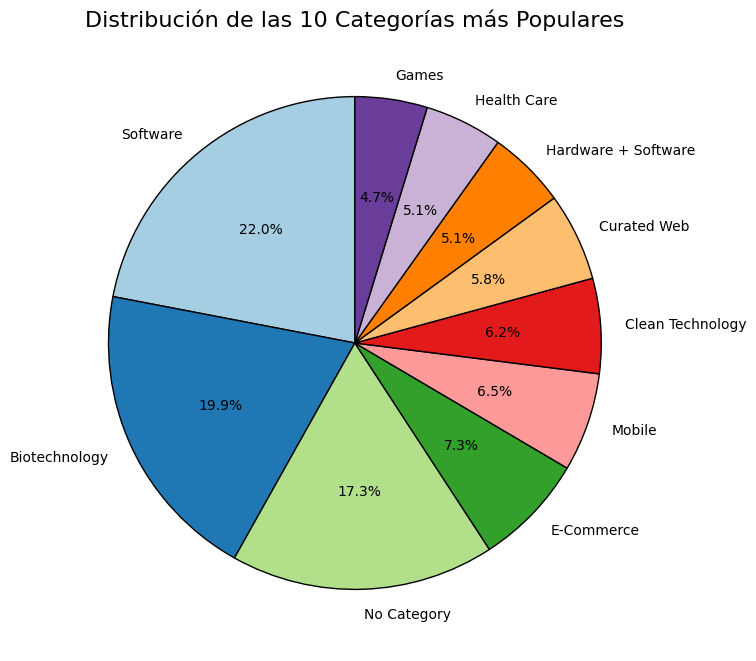

In [ ]:
import matplotlib.pyplot as plt

# Calcular las 10 categorías más frecuentes en la columna 'category_list'
top_categories = big_startup_secsees_df['category_list'].value_counts().head(10)

# Configurar el gráfico de pastel
plt.figure(figsize=(8, 8))  # Tamaño del gráfico
top_categories.plot(
    kind='pie',  # Tipo de gráfico
    autopct='%1.1f%%',  # Mostrar porcentajes en cada sección
    colors=plt.cm.Paired.colors,  # Colores del gráfico
    startangle=90,  # Iniciar el gráfico desde el ángulo 90°
    wedgeprops={'edgecolor': 'black'}  # Agregar borde negro a las secciones
)

# Configurar título y eliminar etiqueta del eje Y
plt.title('Distribución de las 10 Categorías más Populares', fontsize=16)
plt.ylabel('')  # Eliminar etiqueta del eje Y
plt.show()  # Mostrar el gráfico

**Distribución de Status de Startups**

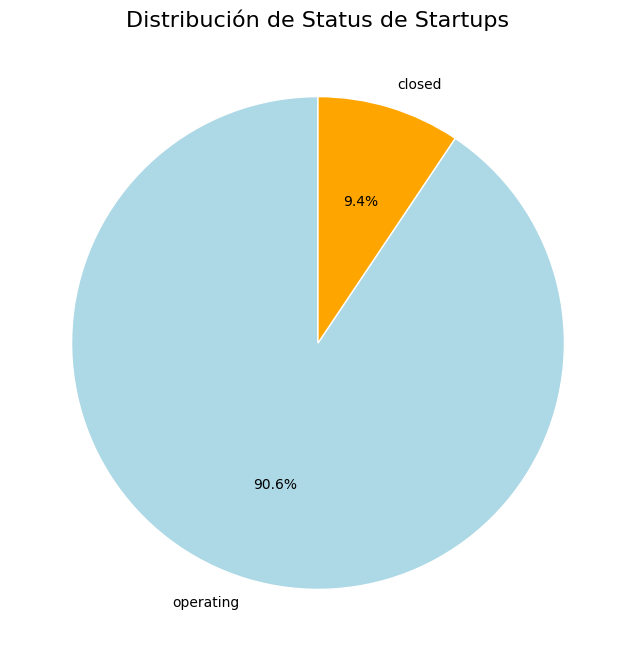

In [ ]:
import matplotlib.pyplot as plt

# Calcular las frecuencias de cada valor en la columna 'status'
status_counts = big_startup_secsees_df['status'].value_counts()

# Configurar el gráfico de pastel
plt.figure(figsize=(8, 8))  # Tamaño del gráfico
status_counts.plot(
    kind='pie',  # Tipo de gráfico
    autopct='%1.1f%%',  # Mostrar porcentajes en cada sección
    colors=['lightblue', 'orange', 'green', 'skyblue'],  # Colores personalizados para cada estado
    startangle=90,  # Iniciar el gráfico desde el ángulo 90°
    wedgeprops={'edgecolor': 'white'}  # Agregar borde blanco a las secciones
)

# Configurar título y eliminar etiqueta del eje Y
plt.title('Distribución de Status de Startups', fontsize=16)
plt.ylabel('')  # Eliminar etiqueta del eje Y
plt.show()  # Mostrar el gráfico

**Rondas de Financiamiento vs Financiamiento Total**

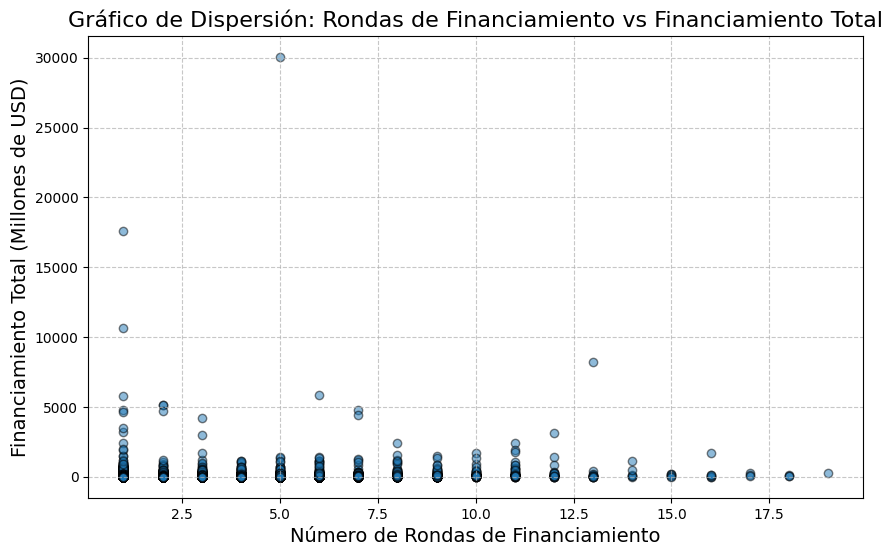

In [ ]:
# Importar la librería Matplotlib para visualización
import matplotlib.pyplot as plt

# Configurar el gráfico de dispersión
plt.figure(figsize=(10, 6))  # Tamaño del gráfico

# Crear un gráfico de dispersión con los datos de rondas de financiamiento y financiamiento total
plt.scatter(
    big_startup_secsees_df['funding_rounds'],  # Eje X: Número de rondas de financiamiento
    big_startup_secsees_df['funding_total_usd'] / 1e6,  # Eje Y: Financiamiento total en millones de USD
    alpha=0.5,  # Transparencia de los puntos para mejorar la legibilidad
    edgecolor='k'  # Borde negro para los puntos
)

# Configurar el título y etiquetas de los ejes
plt.title('Gráfico de Dispersión: Rondas de Financiamiento vs Financiamiento Total', fontsize=16)
plt.xlabel('Número de Rondas de Financiamiento', fontsize=14)
plt.ylabel('Financiamiento Total (Millones de USD)', fontsize=14)

# Añadir una cuadrícula para facilitar la lectura del gráfico
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

**Distribución de las 10 Regiones más Populares**

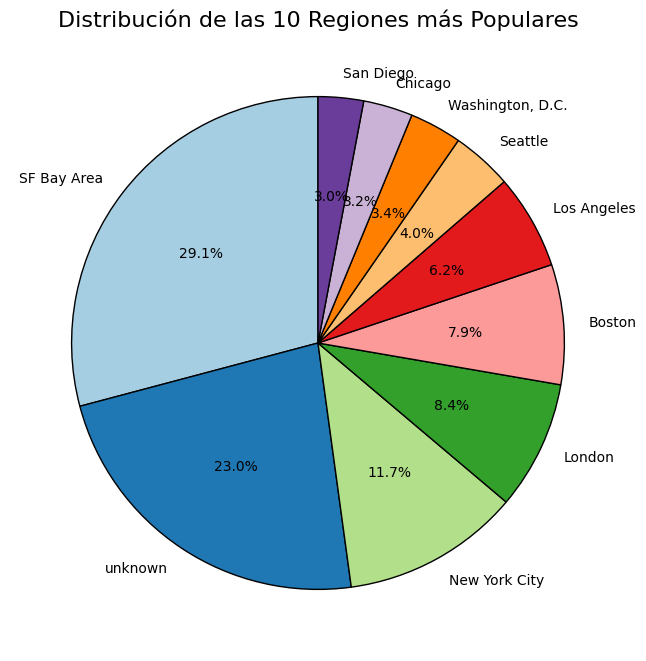

In [ ]:
import matplotlib.pyplot as plt

# Calcular las 10 regiones más frecuentes en la columna 'region'
top_cities = big_startup_secsees_df['region'].value_counts().head(10)

# Configurar el gráfico de pastel
plt.figure(figsize=(8, 8))  # Tamaño del gráfico
top_cities.plot(
    kind='pie',  # Tipo de gráfico
    autopct='%1.1f%%',  # Mostrar porcentajes en cada sección
    colors=plt.cm.Paired.colors,  # Usar una paleta de colores predefinida
    startangle=90,  # Iniciar el gráfico desde el ángulo 90°
    wedgeprops={'edgecolor': 'black'}  # Agregar borde negro a las secciones
)

# Configurar título y eliminar etiqueta del eje Y
plt.title('Distribución de las 10 Regiones más Populares', fontsize=16)
plt.ylabel('')  # Eliminar etiqueta del eje Y
plt.show()  # Mostrar el gráfico

**Top 10 Empresas con Mayor Número de Rondas de Financiamiento**

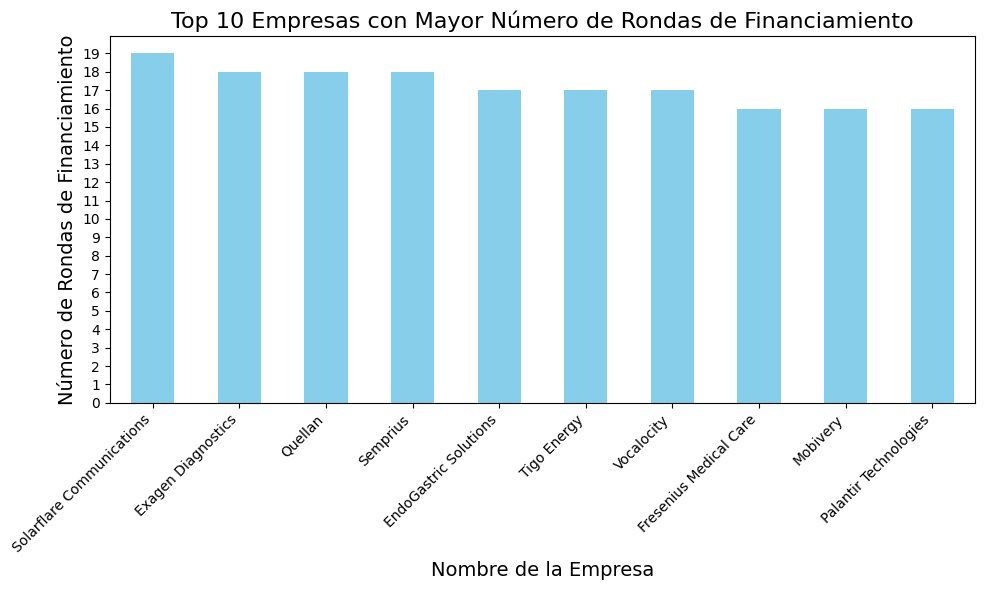

In [ ]:
import matplotlib.pyplot as plt

# Importar la librería Matplotlib para visualización
import matplotlib.pyplot as plt

# Calcular las 10 empresas con el mayor número de rondas de financiamiento
top_companies = big_startup_secsees_df.groupby('name')['funding_rounds'].max().nlargest(10)

# Configurar el gráfico de barras
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
top_companies.plot(
    kind='bar',  # Tipo de gráfico
    color='skyblue'  # Color de las barras
)

# Configurar título y etiquetas de los ejes
plt.title('Top 10 Empresas con Mayor Número de Rondas de Financiamiento', fontsize=16)
plt.xlabel('Nombre de la Empresa', fontsize=14)
plt.ylabel('Número de Rondas de Financiamiento', fontsize=14)

# Rotar las etiquetas del eje X para mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Ajustar las marcas en el eje Y
plt.yticks(ticks=range(0, int(top_companies.max()) + 1))

# Ajustar automáticamente el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()


# **Region con mas financiamiento vs su financiamiento total**

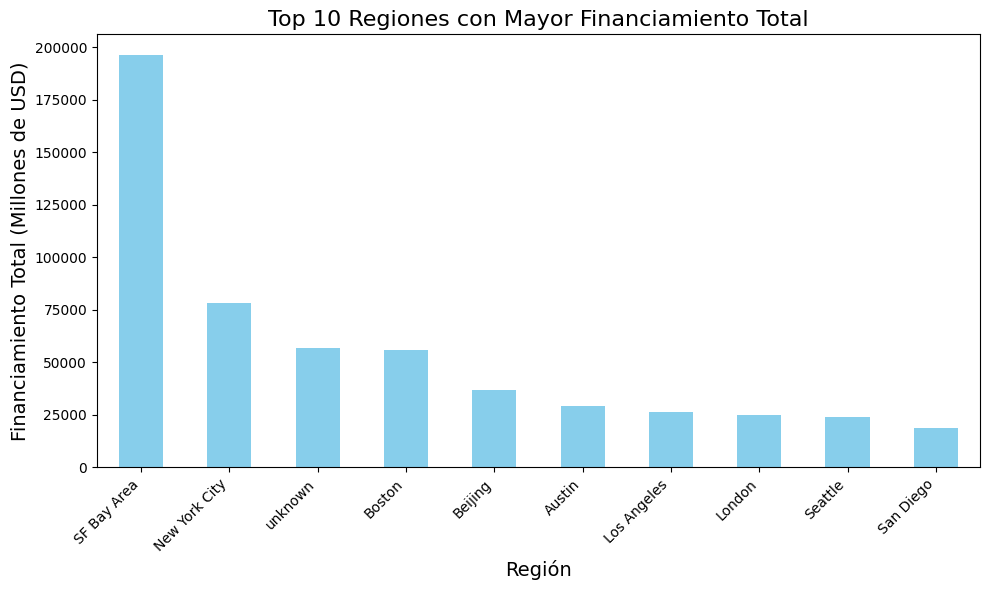

In [ ]:
import matplotlib.pyplot as plt

# Agrupar por región y calcular el financiamiento total, luego convertir a millones de dólares
top_regions = big_startup_secsees_df.groupby('region')['funding_total_usd'].sum().nlargest(10) / 1_000_000

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
top_regions.plot(kind='bar', color='skyblue')

# Personalizar el gráfico
plt.title('Top 10 Regiones con Mayor Financiamiento Total', fontsize=16)
plt.xlabel('Región', fontsize=14)
plt.ylabel('Financiamiento Total (Millones de USD)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

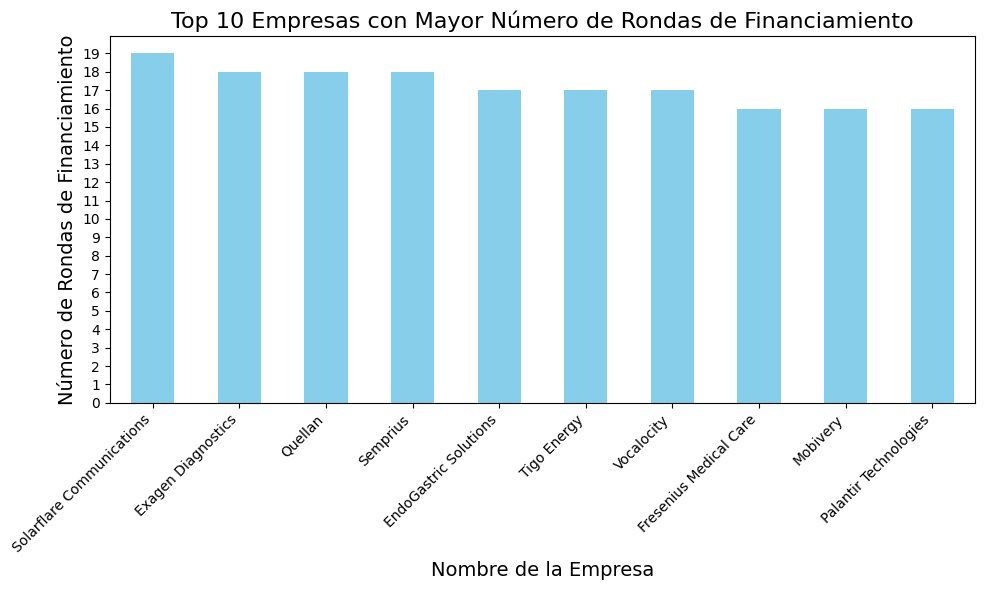

In [ ]:
import matplotlib.pyplot as plt

# Calcular las 10 empresas con el mayor número de rondas de financiamiento
top_companies = big_startup_secsees_df.groupby('name')['funding_rounds'].max().nlargest(10)

# Configurar el gráfico de barras
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
top_companies.plot(
    kind='bar',  # Tipo de gráfico
    color='skyblue'  # Color de las barras
)

# Configurar título y etiquetas de los ejes
plt.title('Top 10 Empresas con Mayor Número de Rondas de Financiamiento', fontsize=16)
plt.xlabel('Nombre de la Empresa', fontsize=14)
plt.ylabel('Número de Rondas de Financiamiento', fontsize=14)

# Rotar las etiquetas del eje X para mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Ajustar las marcas en el eje Y
plt.yticks(ticks=range(0, int(top_companies.max()) + 1))

# Ajustar automáticamente el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()

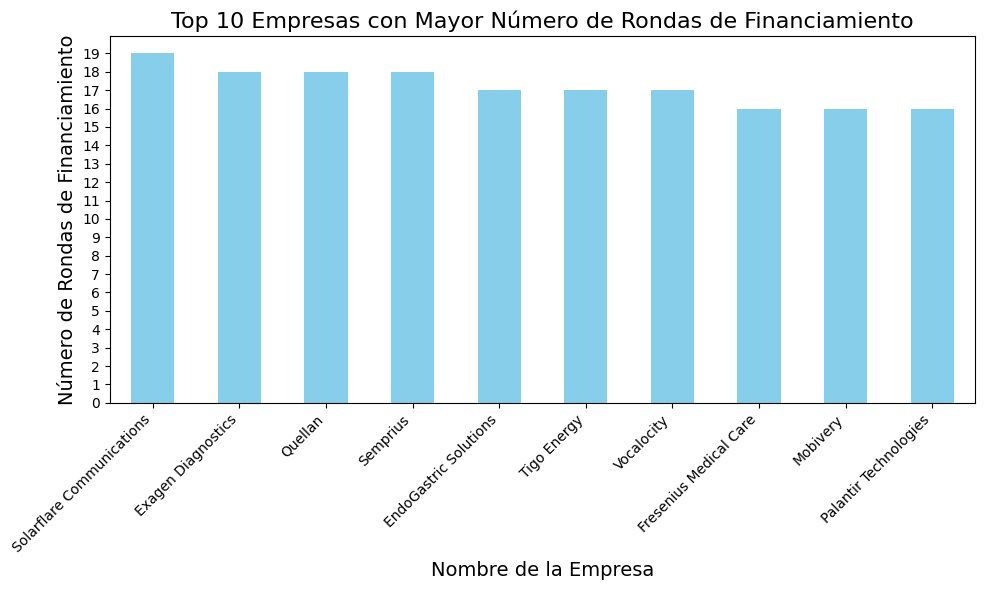

In [ ]:
# Importar la librería Matplotlib para visualización
import matplotlib.pyplot as plt

# Calcular las 10 empresas con el mayor número de rondas de financiamiento
top_companies = big_startup_secsees_df.groupby('name')['funding_rounds'].max().nlargest(10)

# Configurar el gráfico de barras
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
top_companies.plot(
    kind='bar',  # Tipo de gráfico
    color='skyblue'  # Color de las barras
)

# Configurar título y etiquetas de los ejes
plt.title('Top 10 Empresas con Mayor Número de Rondas de Financiamiento', fontsize=16)
plt.xlabel('Nombre de la Empresa', fontsize=14)
plt.ylabel('Número de Rondas de Financiamiento', fontsize=14)

# Rotar las etiquetas del eje X para mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Ajustar las marcas en el eje Y
plt.yticks(ticks=range(0, int(top_companies.max()) + 1))

# Ajustar automáticamente el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# **Estadistica Inferencial**

**Pregunta 1: Regresión Logística**

In [ ]:
import pandas as pd
!pip install statsmodels
import statsmodels.api as sm

# Formulación de hipótesis:
# H0 (Hipótesis nula): No hay correlación significativa entre el financiamiento recibido y la supervivencia de la startup.
# H1 (Hipótesis alternativa): Existe una correlación significativa entre el financiamiento recibido y la supervivencia de la startup.

# Preprocesamiento de datos
# Convertir 'ipo' y 'acquired' a 'operating' en la columna 'status'
big_startup_secsees_df['status'] = big_startup_secsees_df['status'].replace({'ipo': 'operating', 'acquired': 'operating'})

# Eliminar filas con financiamiento igual a 0
filtered_df = big_startup_secsees_df[big_startup_secsees_df['funding_total_usd'] > 0]

# Crear una nueva columna binaria para indicar supervivencia: 1 (operating), 0 (closed)
filtered_df['survival'] = filtered_df['status'].apply(lambda x: 1 if x == 'operating' else 0)

# Variables para el modelo logístico
X = filtered_df['funding_total_usd']  # Variable independiente (dinero de financiamiento)
y = filtered_df['survival']          # Variable dependiente (supervivencia)

# Agregar una constante para la regresión logística
X = sm.add_constant(X)

# Ajustar el modelo de regresión logística
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Imprimir el resumen del modelo
print(result.summary())

# Interpretación del resultado
p_value = result.pvalues['funding_total_usd']  # Valor p del coeficiente de financiamiento
coef = result.params['funding_total_usd']  # Coeficiente de financiamiento

print("\nInterpretación:")
if p_value < 0.05:
    print(f"El valor p ({p_value:.4f}) es menor a 0.05, por lo que se rechaza la hipótesis nula (H0).")
    print("Esto indica que existe una correlación significativa entre el financiamiento recibido y la supervivencia de las startups.")
    if coef > 0:
        print(f"El coeficiente positivo ({coef:.4f}) sugiere que un mayor financiamiento está asociado con una mayor probabilidad de supervivencia.")
    else:
        print(f"El coeficiente negativo ({coef:.4f}) sugiere que un mayor financiamiento está asociado con una menor probabilidad de supervivencia.")
else:
    print(f"El valor p ({p_value:.4f}) es mayor o igual a 0.05, por lo que no se puede rechazar la hipótesis nula (H0).")
    print("Esto indica que no hay suficiente evidencia para concluir que existe una correlación significativa entre el financiamiento recibido y la supervivencia de las startups.")

<ipython-input-22-1319ed582f21>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['survival'] = filtered_df['status'].apply(lambda x: 1 if x == 'operating' else 0)


Optimization terminated successfully.
         Current function value: 0.305797
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               survival   No. Observations:                53583
Model:                          Logit   Df Residuals:                    53581
Method:                           MLE   Df Model:                            1
Date:                Fri, 29 Nov 2024   Pseudo R-squ.:                0.001924
Time:                        23:47:16   Log-Likelihood:                -16386.
converged:                       True   LL-Null:                       -16417.
Covariance Type:            nonrobust   LLR p-value:                 1.909e-15
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.2527      0.016    141.327      0.000       2.221       2.284
funding_

**Pregunta 2: ANOVA**

In [ ]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Eliminar valores nulos en funding_total_usd y filtrar los sectores principales
big_startup_secsees_df = big_startup_secsees_df.dropna(subset=['funding_total_usd'])
top_sectors = big_startup_secsees_df['category_list'].value_counts().head(10).index
big_startup_secsees_df = big_startup_secsees_df[big_startup_secsees_df['category_list'].isin(top_sectors)]

# Convertir funding_total_usd a tipo flotante
big_startup_secsees_df['funding_total_usd'] = pd.to_numeric(big_startup_secsees_df['funding_total_usd'], errors='coerce')

# Agrupar datos por sector
industry_groups = [group['funding_total_usd'].values for _, group in big_startup_secsees_df.groupby('category_list')]

# Realizar ANOVA
anova_result = f_oneway(*industry_groups)

# Resultados de ANOVA
print("ANOVA Resultados:")
print(f"F-Statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4f}")

if anova_result.pvalue < 0.05:
    print("Existe una diferencia significativa en los montos de financiamiento según el sector de la industria.")

    # Prueba Tukey HSD
    tukey_result = pairwise_tukeyhsd(
        endog=big_startup_secsees_df['funding_total_usd'],
        groups=big_startup_secsees_df['category_list'],
        alpha=0.05
    )
    print("\nPrueba Tukey HSD Resultados:")
    print(tukey_result)

    # Mostrar pares con diferencias significativas
    print("\nGrupos con diferencias significativas en financiamiento:")
    for i in range(len(tukey_result.reject)):
        if tukey_result.reject[i]:
            print(f"Diferencia significativa entre {tukey_result.groupsunique[i // len(tukey_result.groupsunique)]} y "
                  f"{tukey_result.groupsunique[i % len(tukey_result.groupsunique)]}.")
else:
    print("No se encontró una diferencia significativa en los montos de financiamiento según el sector de la industria.")


<ipython-input-23-f0e08b0cea82>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_startup_secsees_df['funding_total_usd'] = pd.to_numeric(big_startup_secsees_df['funding_total_usd'], errors='coerce')


ANOVA Resultados:
F-Statistic: 40.8077, p-value: 0.0000
Existe una diferencia significativa en los montos de financiamiento según el sector de la industria.

Prueba Tukey HSD Resultados:
                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
       group1              group2          meandiff    p-adj      lower          upper      reject
--------------------------------------------------------------------------------------------------
      Biotechnology    Clean Technology   8955389.7805 0.0007   2359535.0231  15551244.5379   True
      Biotechnology         Curated Web -17698319.2287    0.0 -24489759.0705 -10906879.3869   True
      Biotechnology          E-Commerce  -4216076.4343  0.493 -10425474.8475   1993321.9789  False
      Biotechnology               Games -15352296.6653    0.0 -22695247.1195  -8009346.2111   True
      Biotechnology Hardware + Software -10357775.5484 0.0002 -17474582.8124  -3240968.2845   True
      Biotechnology  

In [ ]:
import statsmodels.api as sm

# Preprocesamiento
# Convertir 'ipo' y 'acquired' a 'operating' en la columna 'status'
big_startup_secsees_df['status'] = big_startup_secsees_df['status'].replace({'ipo': 'operating', 'acquired': 'operating'})

# Crear una columna binaria para supervivencia: 1 (operating), 0 (closed)
big_startup_secsees_df['survival'] = big_startup_secsees_df['status'].apply(lambda x: 1 if x == 'operating' else 0)

# Variables independientes (número de rondas de financiamiento) y dependiente (supervivencia)
X = big_startup_secsees_df['funding_rounds']  # Número de rondas de financiamiento
y = big_startup_secsees_df['survival']        # Supervivencia

# Agregar constante al modelo
X = sm.add_constant(X)

# Ajustar el modelo de regresión logística
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Imprimir resultados
print(result.summary())

# Interpretación
p_value_rounds = result.pvalues['funding_rounds']  # Valor p para rondas de financiamiento
coef_rounds = result.params['funding_rounds']      # Coeficiente para rondas de financiamiento

print("\nInterpretación:")
if p_value_rounds < 0.05:
    print(f"El valor p ({p_value_rounds:.4f}) es menor a 0.05, lo que indica que el número de rondas de financiamiento tiene un efecto significativo en la supervivencia de las startups.")
    if coef_rounds > 0:
        print(f"El coeficiente positivo ({coef_rounds:.4f}) sugiere que un mayor número de rondas de financiamiento incrementa la probabilidad de supervivencia.")
    else:
        print(f"El coeficiente negativo ({coef_rounds:.4f}) sugiere que un mayor número de rondas de financiamiento reduce la probabilidad de supervivencia.")
else:
    print(f"El valor p ({p_value_rounds:.4f}) es mayor o igual a 0.05, por lo que no se puede concluir que el número de rondas de financiamiento tenga un efecto significativo en la supervivencia de las startups.")

Optimization terminated successfully.
         Current function value: 0.372669
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               survival   No. Observations:                18174
Model:                          Logit   Df Residuals:                    18172
Method:                           MLE   Df Model:                            1
Date:                Fri, 29 Nov 2024   Pseudo R-squ.:                 0.01459
Time:                        23:47:32   Log-Likelihood:                -6772.9
converged:                       True   LL-Null:                       -6873.2
Covariance Type:            nonrobust   LLR p-value:                 1.599e-45
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.4679      0.042     35.067      0.000       1.386       1.550
funding_rounds   

# **Machine Learning**

Clustering: Agrupar las startups según su financiamiento y su numero de rondas de financiamiento utilizando K-means

<ipython-input-25-4a16283bf777>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['funding_total_usd_millions'] = data['funding_total_usd'] / 1_000_000
<ipython-input-25-4a16283bf777>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['founded_at'] = pd.to_datetime(data['founded_at'], errors='coerce')
<ipython-input-25-4a16283bf777>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

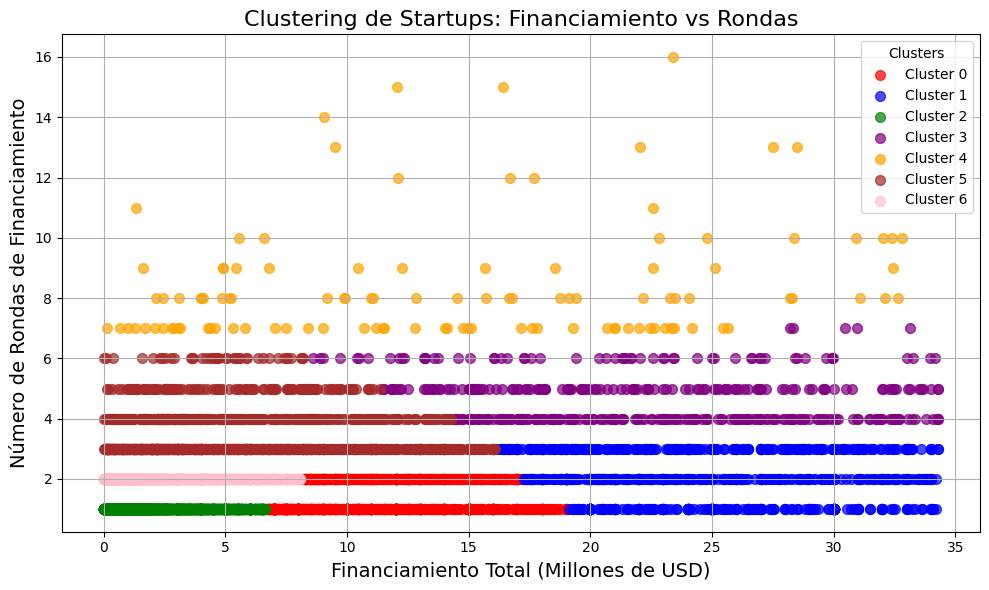

Centroides de los Clusters (en escala original):
   funding_total_usd_millions  funding_rounds
0                       11.34               1
1                       24.53               2
2                        1.53               1
3                       22.26               5
4                       14.62               8
5                        5.79               4
6                        2.63               2

Información Adicional por Cluster con Categoría Promedio:
         avg_funding  avg_rounds   avg_region avg_founded_at   avg_category
cluster                                                                    
0              11.34        1.31  SF Bay Area     2005-01-13       Software
1              24.53        1.92  SF Bay Area     2005-03-25  Biotechnology
2               1.53        1.00      unknown     2008-05-10       Software
3              22.29        4.69  SF Bay Area     2005-07-17  Biotechnology
4              14.62        8.44  SF Bay Area     2006-06-01  Biotec

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from collections import Counter

# Preprocesamiento
big_startup_secsees_df['status'] = big_startup_secsees_df['status'].replace({'ipo': 'operating', 'acquired': 'operating'})

# Filtrar datos relevantes: solo filas con financiamiento > 0 y rondas de financiamiento válidas
data = big_startup_secsees_df[(big_startup_secsees_df['funding_total_usd'] > 0) &
                               (big_startup_secsees_df['funding_rounds'].notnull())]

# Financiamiento en millones de USD
data['funding_total_usd_millions'] = data['funding_total_usd'] / 1_000_000

# Convertir fechas a formato datetime
data['founded_at'] = pd.to_datetime(data['founded_at'], errors='coerce')

# Función para descartar outliers usando IQR (solo en financiamiento)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Eliminar outliers en la columna de financiamiento
data = remove_outliers(data, 'funding_total_usd_millions')

# Seleccionar características para clustering
X = data[['funding_total_usd_millions', 'funding_rounds']]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar KMeans con 7 clusters
kmeans = KMeans(n_clusters=7, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Fijar colores para los clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink']
data['color'] = data['cluster'].apply(lambda x: colors[x])

# Visualizar los clusters
plt.figure(figsize=(10, 6))
for cluster in range(7):
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(
        cluster_data['funding_total_usd_millions'],
        cluster_data['funding_rounds'],
        c=colors[cluster],
        label=f'Cluster {cluster}',
        s=50,
        alpha=0.7
    )

plt.title('Clustering de Startups: Financiamiento vs Rondas', fontsize=16)
plt.xlabel('Financiamiento Total (Millones de USD)', fontsize=14)
plt.ylabel('Número de Rondas de Financiamiento', fontsize=14)
plt.legend(title='Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar los centroides redondeados
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=['funding_total_usd_millions', 'funding_rounds'])
centroids_df['funding_total_usd_millions'] = centroids_df['funding_total_usd_millions'].round(2)
centroids_df['funding_rounds'] = centroids_df['funding_rounds'].round(0).astype(int)

print("Centroides de los Clusters (en escala original):")
print(centroids_df)

def most_common_category(x):
    return Counter(x).most_common(1)[0][0] if len(x) > 0 else 'Desconocido'

related_info = data.groupby('cluster').agg(
    avg_funding=('funding_total_usd_millions', 'mean'),
    avg_rounds=('funding_rounds', 'mean'),
    avg_region=('region', lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Desconocido'),
    avg_founded_at=('founded_at', lambda x: x.mean() if not x.isna().all() else np.nan),
    avg_category=('category_list', most_common_category)
)

# Convertir la fecha promedio de creación a un formato legible
related_info['avg_founded_at'] = pd.to_datetime(related_info['avg_founded_at']).dt.date

# Visualizar la tabla actualizada
print("\nInformación Adicional por Cluster con Categoría Promedio:")
print(related_info)

**Machine Learning: predecir cuánta cantidad de financiamiento en USD necesitaría una startup para tener al menos un 99% de probabilidades de sobrevivir**

In [ ]:
# Filtrar filas con financiamiento > 0
data = big_startup_secsees_df[big_startup_secsees_df['funding_total_usd'] > 0]

# Variables independientes y dependiente
X = data[['funding_total_usd']]  # Solo financiamiento total
y = (data['status'] == 'operating').astype(int)

# Añadir nombres de las empresas
X['name'] = data['name']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo de regresión logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train[['funding_total_usd']], y_train)

# Calcular financiamiento necesario para ~99% de probabilidad de supervivencia
def calculate_threshold(probability):
    log_odds = np.log(probability / (1 - probability))
    threshold = (log_odds - model.intercept_[0]) / model.coef_[0][0]
    return threshold

threshold_99 = calculate_threshold(0.99)  # ~99% de probabilidad

# Testeo del modelo en 10 empresas
X_test_sample = X_test.sample(10, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]
y_pred_prob = model.predict_proba(X_test_sample[['funding_total_usd']])[:, 1]  # Probabilidades de supervivencia

# Crear tabla con resultados
test_results = pd.DataFrame({
    'Company Name': X_test_sample['name'],
    'Funding Total (USD)': X_test_sample['funding_total_usd'],
    'Actual Status (1=Operating)': y_test_sample.values,
    'Predicted Survival Probability (%)': (y_pred_prob * 100).round(2)
})

# Imprimir tabla de resultados
print("\nResultados del Testeo en 10 Empresas:")
print(test_results)

# Mostrar umbral calculado
print(f"\nEl umbral mínimo de financiamiento para una probabilidad de supervivencia del ~99% es: ${threshold_99:,.2f}")


<ipython-input-27-682fb51f8ad8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['name'] = data['name']


NameError: name 'train_test_split' is not defined